For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is its performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import seaborn as sns
import spacy
import warnings
from bokeh.io import output_notebook
from bokeh.layouts import row
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category10
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from nlp_help import LsaPlotting, eval_clusters, make_kmeans_clusters
from nlp_help import fit_and_predict, kmeans_centroid_plot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, normalize, Normalizer
from sklearn.tree import DecisionTreeClassifier
from typing import Dict, Tuple
import os

# Display preferences.
%matplotlib inline
output_notebook()
pd.options.display.float_format = '{:.3f}'.format
pyLDAvis.enable_notebook()
sns.set_style('white')
warnings.filterwarnings(#"ignore", category=DeprecationWarning)
   action='ignore',
   module='scipy',
   message='internal gelsd'
)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 

Loading BokehJS ...

# Data Cleaning, Processing, and Language Parsing

In [2]:
files = sorted(os.listdir('./data/'))

presidents = sorted(["washington", "jefferson", "lincoln", "fdr", 
                     "eisenhower", "kennedy", "reagan", "ghwbush", "clinton",
                     "obama"])

assert len(files) == len(presidents)

In [3]:
def text_cleaner(text: str) -> str:
    """Function to strip all characters except letters in words."""
    text = re.sub(r'--', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[\[].*?[\]]", "", text)
    text = re.sub(r"[\<].*?[\>]", "", text)
    text = ' '.join(text.split())
    return text

In [4]:
clean_docs = []
for file_name, president in zip(files, presidents):
    with open(f'./data/{file_name}') as f:
        document = f.read()
        clean_doc = text_cleaner(document)
        clean_docs.append((clean_doc, president))

In [5]:
for document, pres in clean_docs:
    print(f'{pres.upper()}:\n', document[:200], '\n')

CLINTON:
 My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in the depth of winter, but by the words we speak and the faces we show the world, we force the spring. A  

EISENHOWER:
 My friends, before I begin the expression of those thoughts that I deem appropriate to this moment, would you permit me the privilege of uttering a little private prayer of my own. And I ask that you  

FDR:
 I am certain that my fellow Americans expect that on my induction into the Presidency I will address them with a candor and a decision which the present situation of our Nation impels. This is preemin 

GHWBUSH:
 Mr. Chief Justice, Mr. President, Vice President Quayle, Senator Mitchell, Speaker Wright, Senator Dole, Congressman Michael, and fellow citizens, neighbors, and friends: There is a man here who has e 

JEFFERSON:
 Friends and Fellow Citizens: Called upon to undertake the duties of the first executive office of our country, I avail myself of the pres

In [6]:
# Find number of characters in all docs.
print(len(clean_doc))

8606


In [7]:
# Define nlp as spacy.
nlp = spacy.load('en')
# Create an empty list for df.
df_list = []


def nlp_text(text_file: str) -> spacy.tokens.doc.Doc:
    """Function that takes a text file and returns a spacy.Doc."""
    return nlp(text_file)


def sentences(doc_nlp: spacy.tokens.doc.Doc,
              speaker: str) -> Tuple:
    """Function that a spacy.tokens.doc.Doc, lemmatizes the first string and 
    returns a list with the lemma and speaker name.
    """
    return [[sent.lemma_, speaker] for sent in doc_nlp.sents]


def sentences_to_df(sents):
    """Function that takes a string and returns a df."""
    return pd.DataFrame(sents)


# Calling each function.
for doc, pres in clean_docs:
    parsed = nlp_text(doc)
    sents = sentences(parsed, pres)
    df = sentences_to_df(sents)
    df_list.append(df)

In [8]:
sent_df = pd.concat([*df_list])

In [9]:
# Rename columns.
sent_df.columns = ['sentence', 'President']

# Check the count of sents per President.
sent_df.President.value_counts()

ghwbush       145
lincoln       139
reagan        130
eisenhower    121
obama         113
fdr            86
clinton        82
kennedy        53
jefferson      42
washington     25
Name: President, dtype: int64

In [10]:
# Filter out pronouns from results.
sent_df['sentence'] = sent_df['sentence'].str.replace('-PRON-', '')

# Creating Features

In [11]:
# Split into train/eval/holdout part 1.
X = sent_df.sentence
y = sent_df.President
X_train_eval, X_holdout, y_train_eval, y_holdout = train_test_split(
    X, y, test_size=0.25, random_state=15)

In [12]:
# Split into train/eval/holdout part 2.
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train_eval, y_train_eval, test_size=0.25, random_state=15)

In [13]:
base_param_dict = {'strip_accents': 'unicode',
                   'lowercase': True,
                   'stop_words': 'english',
                   'ngram_range': (1, 3),
                   'max_df': 0.5,
                   'min_df': 5,
                   'max_features': 1000}

## Count Vectorizer - Bag of Words (BoW)

In [14]:
bow = CountVectorizer(**base_param_dict)
tf_vectorizer = CountVectorizer(**base_param_dict)

# Fit/transform document-term matrix.
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

(526, 219)


In [15]:
_bow_train = bow.fit_transform(X_train)
_bow_eval = bow.transform(X_eval)
_bow_holdout = bow.transform(X_holdout)
assert len(X_train) == _bow_train.shape[0]  # df and sparse-matrix

feature_names = bow.get_feature_names()

X_train_bow = pd.DataFrame(_bow_train.toarray(), columns=feature_names)
X_eval_bow = pd.DataFrame(_bow_eval.toarray(), columns=feature_names)
X_holdout_bow = pd.DataFrame(_bow_holdout.toarray(), columns=feature_names)

In [16]:
# Calculate weights on training data.
weights_bow = np.asarray(X_train_bow.sum(axis=0)).ravel()
weights_bow_df = pd.DataFrame(
    {'word': bow.get_feature_names(), 'cum_weight': weights_bow})
print("\nTrain Weights:\n", weights_bow_df.sort_values(
    by='cum_weight', ascending=False).head(10))

# Calculate weights on eval data.
weights_bow_eval = np.asarray(X_eval_bow.sum(axis=0)).ravel()
weights_bow_eval_df = pd.DataFrame(
    {'word': bow.get_feature_names(), 'cum_weight': weights_bow_eval})
print("\nEval Weights:\n", weights_bow_eval_df.sort_values(
    by='cum_weight', ascending=False).head(10))


Train Weights:
            word  cum_weight
151      people          51
216       world          46
84   government          42
136      nation          36
180       shall          35
197        time          33
125         man          31
83         good          30
112         let          29
124        make          28

Eval Weights:
            word  cum_weight
136      nation          16
216       world          15
151      people          15
150       peace          13
84   government          12
77         free          11
125         man          11
112         let          11
83         good          11
6       america          10


## Tfidf

In [17]:
tfidf = TfidfVectorizer(**base_param_dict)
dtm_tfidf = tfidf.fit_transform(X_train)
print(dtm_tfidf.shape)

(526, 219)


In [18]:
_tfidf_train = tfidf.fit_transform(X_train)
_tfidf_eval = tfidf.transform(X_eval)
_tfidf_holdout = tfidf.transform(X_holdout)
assert len(X_train) == _tfidf_train.shape[0]  # df and sparse-matrix

feature_names_tfidf = tfidf.get_feature_names()

X_train_tfidf = pd.DataFrame(
    _tfidf_train.toarray(), columns=feature_names_tfidf)
X_eval_tfidf = pd.DataFrame(
    _tfidf_eval.toarray(), columns=feature_names_tfidf)
X_holdout_tfidf = pd.DataFrame(
    _tfidf_holdout.toarray(), columns=feature_names_tfidf)

In [19]:
# Calculate weights on training data.
weights = np.asarray(X_train_tfidf.mean(axis=0)).ravel()
weights_df = pd.DataFrame(
    {'word': tfidf.get_feature_names(), 'avg_weight': weights})
print("\nTrain Weights:\n", weights_df.sort_values(
    by='avg_weight', ascending=False).head(10))

# Calculate weights on eval data.
weights = np.asarray(X_eval_tfidf.mean(axis=0)).ravel()
weights_df = pd.DataFrame(
    {'word': tfidf.get_feature_names(), 'avg_weight': weights})
print("\nEval Weights:\n", weights_df.sort_values(
    by='avg_weight', ascending=False).head(10))


Train Weights:
            word  avg_weight
151      people       0.032
216       world       0.029
112         let       0.025
197        time       0.025
84   government       0.024
136      nation       0.024
180       shall       0.023
114        life       0.021
215        work       0.021
85        great       0.020

Eval Weights:
           word  avg_weight
136     nation       0.037
216      world       0.031
77        free       0.029
151     people       0.027
112        let       0.026
98        hope       0.026
9    americans       0.025
125        man       0.024
6      america       0.024
114       life       0.024


## Latent Semantic Analysis (LSA) - Bag of Words (BoW)

In [20]:
svd = TruncatedSVD(n_components=100)

lsa_pipe = make_pipeline(svd, Normalizer())

# Fit with training data, transform test data.
X_train_bow_lsa = lsa_pipe.fit_transform(X_train_bow)
X_eval_bow_lsa = lsa_pipe.transform(X_eval_bow)
X_holdout_bow_lsa = lsa_pipe.transform(X_holdout_bow)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_bow_lsa, index=X_train)

# Look at values from first 5 components.
for i in range(5):
    print(f'\nComponent {i}:')
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5])

Percent variance captured by components: 83.74059472829443

Component 0:
sentence
at the same time , the candid citizen must confess that if the policy of the government upon vital question affect the whole people be to be irrevocably fix by decision of the supreme court , the instant  be make in ordinary litigation between party in personal action the people will have cease to be  own ruler , have to that extent practically resign  government into the hand of that eminent tribunal .   0.549
 know , indeed , that some honest man fear that a republican government can not be strong , that this government be not strong enough ; but would the honest patriot , in the full tide of successful experiment , abandon a government which have so far keep  free and firm on the theoretic and visionary fear that this government , the world 's good hope , may by possibility want energy to preserve  ?          0.540
 be call as a people to give testimony in the sight of the world to  faith that the futu

In [21]:
bow_lsa_plots = LsaPlotting(X_train_lsa=X_train_bow_lsa, y_train=y_train,
                            X_eval_lsa=X_eval_bow_lsa, y_eval=y_eval)

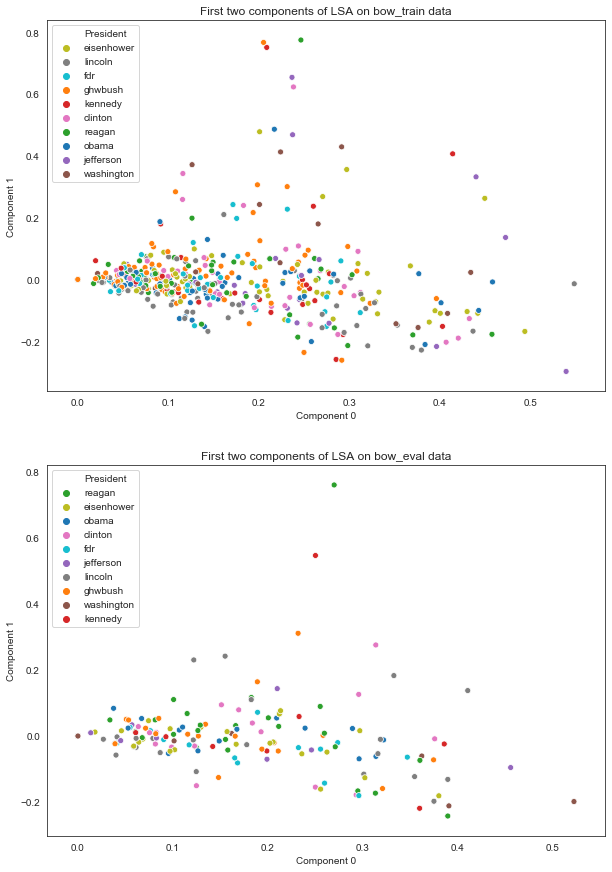

In [22]:
train_title_2d = 'First two components of LSA on bow_train data'
eval_title_2d = 'First two components of LSA on bow_eval data'

bow_lsa_plots.compare_plot_2d(train_title=train_title_2d,
                              eval_title=eval_title_2d)

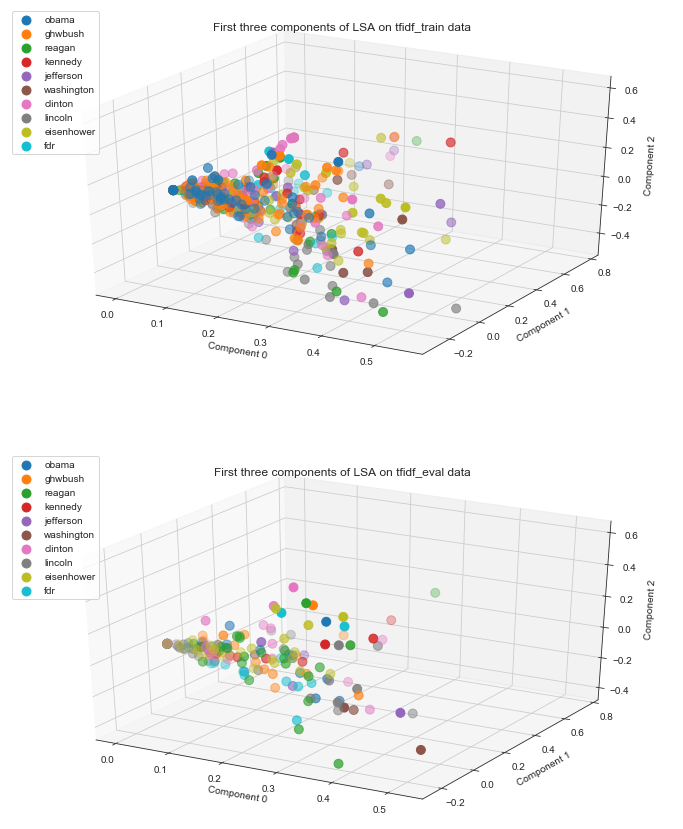

In [23]:
train_title_3d = 'First three components of LSA on tfidf_train data'
eval_title_3d = 'First three components of LSA on tfidf_eval data'

bow_lsa_plots.compare_plot_3d(train_title=train_title_3d,
                              eval_title=eval_title_3d)

In [24]:
bow_lsa_plots.compare_plot_interactive(X_train=X_train, X_eval=X_eval)

Loading BokehJS ...

## Latent Semantic Analysis (LSA) - Tfidf

In [25]:
X_train_lsa = lsa_pipe.fit_transform(X_train_tfidf)
X_eval_lsa = lsa_pipe.transform(X_eval_tfidf)
X_holdout_lsa = lsa_pipe.transform(X_holdout_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

# Look at values from first 5 components.
for i in range(5):
    print(f'\nComponent {i}:')
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5])

Percent variance captured by components: 75.88242990195008

Component 0:
sentence
at the same time , the candid citizen must confess that if the policy of the government upon vital question affect the whole people be to be irrevocably fix by decision of the supreme court , the instant  be make in ordinary litigation between party in personal action the people will have cease to be  own ruler , have to that extent practically resign  government into the hand of that eminent tribunal .   0.468
 be call as a people to give testimony in the sight of the world to  faith that the future shall belong to the free .                                                                                                                                                                                                                                                                                                    0.462
at a moment when the outcome of  revolution be most in doubt , the father of  nation ord

In [26]:
tfidf_lsa_plots = LsaPlotting(X_train_lsa=X_train_lsa, y_train=y_train,
                              X_eval_lsa=X_eval_lsa, y_eval=y_eval)

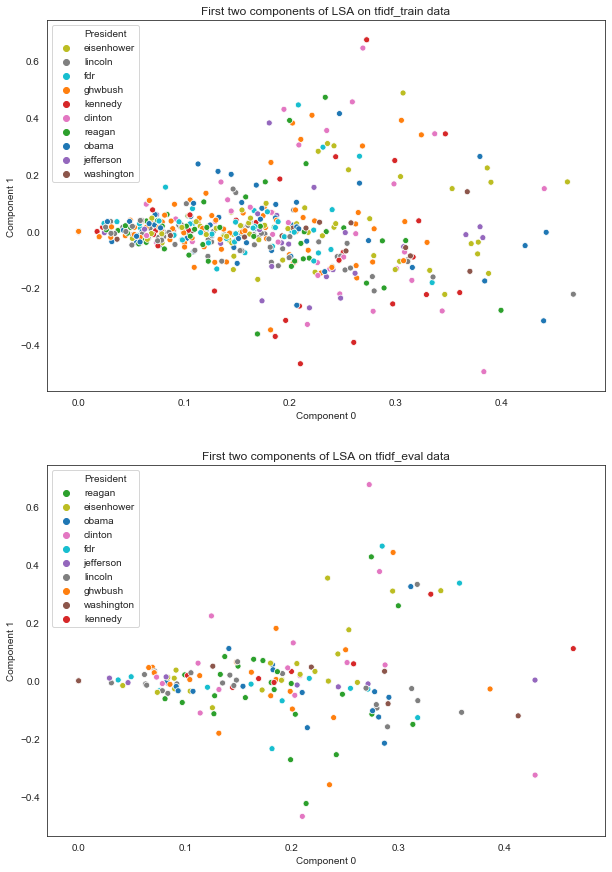

In [27]:
train_title_2d = 'First two components of LSA on tfidf_train data'
eval_title_2d = 'First two components of LSA on tfidf_eval data'

tfidf_lsa_plots.compare_plot_2d(train_title=train_title_2d,
                                eval_title=eval_title_2d)

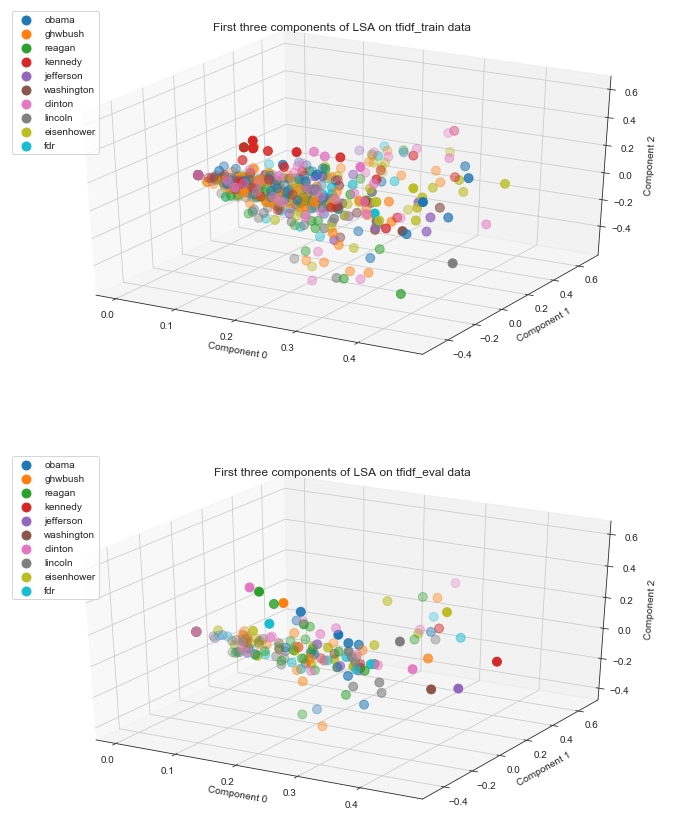

In [28]:
train_title_3d = 'First three components of LSA on tfidf_train data'
eval_title_3d = 'First three components of LSA on tfidf_eval data'

tfidf_lsa_plots.compare_plot_3d(train_title=train_title_3d,
                                eval_title=eval_title_3d)

In [29]:
tfidf_lsa_plots.compare_plot_interactive(X_train=X_train, X_eval=X_eval)

Loading BokehJS ...

# Clustering Models

## Clustering - BoW

In [30]:
# Make KMeans.
make_kmeans_clusters(X_train_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.17707527400109827

KMeans col_0    0   1
row_0         
0      467   0
1        0  59 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Clusters 2	 silhoutte                     0.35428118143259535

MiniKatch col_0  0    1
row_0        
0      1   34
1      1  490 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.18112147547044696

KMeans col_0   0    1  2
row_0            
0      46    0  0
1       0 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Clusters 10	 silhoutte                     0.052045647850134734

MiniKatch col_0   0  1  2   3    4   5  6  7   8   9
row_0                                     
0       0  0  0   0    1   0  0  0   0   0
1       3  0  0   0    0   1  0  0   1   0
2       0  0  0   0    0   1  0  0   0   0
3      33  4  1  14  361  26  2  1  47  11
4       0  0  0   0    5   1  0  0   0   0
5       0  0  0   1    0   0  0  0   0   0
6       1  1  0   0    2   0  0  0   0   0
7       1  0  0   0    1   0  0  0   0   0
8       0  0  0   0    2   0  2  0   0   0
9       1  0  0   0    1   0  0  0   0   0 



In [31]:
# Re-run KMeans and extract cluster information.
model_bow = KMeans(n_clusters=4, random_state=15).fit(X_train_bow)

In [32]:
eval_clusters(model_bow, X_train_bow, X_eval_bow, X_holdout_bow)

Train set aggregated: 
            act  action  address  administration  advance   age  america  \
clusters                                                                  
0        0.020   0.012    0.008           0.008    0.010 0.010    0.043   
1        0.000   0.000    0.000           0.000    0.000 0.000    0.500   
2        0.000   0.062    0.062           0.125    0.062 0.000    0.062   
3        0.000   0.062    0.000           0.000    0.000 0.000    0.125   

          american  american people  americans  ...  value  view   war   way  \
clusters                                        ...                            
0            0.016            0.008      0.030  ...  0.014 0.012 0.022 0.020   
1            0.000            0.000      0.000  ...  0.000 0.000 0.500 0.000   
2            0.062            0.062      0.000  ...  0.000 0.000 0.000 0.062   
3            0.062            0.000      0.000  ...  0.000 0.062 0.000 0.000   

          woman  word  work  world  year  yo

## Clustering - Tfidf

In [33]:
# Make KMeans.
make_kmeans_clusters(X_train_tfidf) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.021273983757042512

KMeans col_0    0   1
row_0         
0      446   0
1        0  80 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Clusters 2	 silhoutte                     0.019862081673415393

MiniKatch col_0    0    1
row_0          
0      132  374
1        4   16 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.021789879866333076

KMeans col_0    0   1   2
row_0             
0      362   0 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 10	 silhoutte                     0.029081209004780808

KMeans col_0    0   1   2   3   4   5   6   7   8   9
row_0                                         
0      181   0   0   0   0   0   0   0   0   0
1        0  28   0   0   0   0   0   0   0   0
2        0   0  40   0   0   0   0   0   0   0
3        0   0   0  56   0   0   0   0   0   0
4        0   0   0   0  28   0   0   0   0   0
5        0   0   0   0   0  33   0   0   0   0
6        0   0   0   0   0   0  51   0   0   0
7        0   0   0   0   0   0   0  33   0   0
8        0   0   0   0   0   0   0   0  19   0
9        0   0   0   0   0   0   0   0   0  57 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=N

In [34]:
# Re-run KMeans and extract cluster information.
model_tfidf = KMeans(n_clusters=5, random_state=15).fit(X_train_tfidf)

In [35]:
eval_clusters(model_tfidf, X_train_tfidf, X_eval_tfidf, X_holdout_tfidf)

Train set aggregated: 
            act  action  address  administration  advance   age  america  \
clusters                                                                  
0        0.009   0.005    0.005           0.003    0.005 0.006    0.019   
1        0.000   0.000    0.000           0.000    0.000 0.000    0.037   
2        0.000   0.000    0.000           0.037    0.000 0.000    0.026   
3        0.000   0.000    0.000           0.000    0.022 0.000    0.000   
4        0.008   0.021    0.000           0.023    0.000 0.000    0.012   

          american  american people  americans  ...  value  view   war   way  \
clusters                                        ...                            
0            0.003            0.000      0.014  ...  0.005 0.006 0.014 0.006   
1            0.027            0.000      0.000  ...  0.000 0.000 0.000 0.000   
2            0.000            0.000      0.000  ...  0.000 0.000 0.000 0.037   
3            0.032            0.000      0.000  ..

## Clustering - LSA (BoW)

In [36]:
# Make KMeans.
make_kmeans_clusters(X_train_bow_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.024567019684066563

KMeans col_0    0    1
row_0          
0      416    0
1        0  110 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Clusters 2	 silhoutte                     0.02064105788080622

MiniKatch col_0    0   1
row_0         
0      139  81
1      207  99 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.030386594896379248

KMeans col_0   0   1    2
row_0             
0      63   0   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 10	 silhoutte                     0.05504972903521036

KMeans col_0   0   1   2   3   4    5   6  7   8   9
row_0                                        
0      11   0   0   0   0    0   0  0   0   0
1       0  19   0   0   0    0   0  0   0   0
2       0   0  18   0   0    0   0  0   0   0
3       0   0   0  23   0    0   0  0   0   0
4       0   0   0   0  38    0   0  0   0   0
5       0   0   0   0   0  355   0  0   0   0
6       0   0   0   0   0    0  18  0   0   0
7       0   0   0   0   0    0   0  8   0   0
8       0   0   0   0   0    0   0  0  22   0
9       0   0   0   0   0    0   0  0   0  14 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassign

In [37]:
# Re-run KMeans and extract cluster information.
model_bow_lsa = KMeans(n_clusters=4, random_state=15).fit(X_train_bow_lsa)

In [38]:
# Change np arrays to dfs, headings=col_names.
col_names = [f'comp_{i}' for i in range(X_train_bow_lsa.shape[1])]

_df_train = pd.DataFrame(X_train_bow_lsa, columns=col_names)
_df_eval = pd.DataFrame(X_eval_bow_lsa, columns=col_names)
_df_holdout = pd.DataFrame(X_eval_bow_lsa, columns=col_names)

eval_clusters(model_bow_lsa, _df_train, _df_eval, _df_holdout)

Train set aggregated: 
           comp_0  comp_1  comp_2  comp_3  comp_4  comp_5  comp_6  comp_7  \
clusters                                                                   
0          0.089  -0.006   0.015  -0.033   0.012  -0.060   0.022  -0.014   
1          0.298  -0.085   0.342  -0.050   0.109   0.173  -0.011   0.052   
2          0.265  -0.037  -0.143  -0.093  -0.060   0.094   0.040  -0.057   
3          0.166   0.078   0.015   0.027  -0.045  -0.111  -0.015   0.008   

          comp_8  comp_9  ...  comp_90  comp_91  comp_92  comp_93  comp_94  \
clusters                  ...                                                
0          0.007  -0.012  ...    0.006    0.010    0.003   -0.001    0.006   
1         -0.077   0.033  ...   -0.002    0.003   -0.001    0.002    0.008   
2          0.004  -0.045  ...   -0.014   -0.008    0.002   -0.005   -0.000   
3          0.005  -0.006  ...   -0.012    0.008    0.021    0.004   -0.011   

          comp_95  comp_96  comp_97  comp_98  comp

In [39]:
kmeans_centroid_plot(model=model_bow_lsa, train_df=_df_train, eval_df=_df_eval,
                     X_train=X_train, y_train=y_train, X_eval=X_eval,
                     y_eval=y_eval, columns=col_names,
                     train_title='KMeans clustering on LSA - BoW train data',
                     eval_title='KMeans clustering on LSA - BoW eval data')

## Clustering - LSA (Tfidf)

In [40]:
make_kmeans_clusters(X_train_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.020927688041193753

KMeans col_0    0    1
row_0          
0      379    0
1        0  147 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
Clusters 2	 silhoutte                     0.019441089553821244

MiniKatch col_0   0    1
row_0         
0      81  169
1      82  194 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.019868180211453007

KMeans col_0    0    1    2
row_0               
0      269 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=15, tol=0.0001, verbose=0)
Clusters 10	 silhoutte                     0.040820718971636326

KMeans col_0    0   1   2   3   4   5   6   7   8   9
row_0                                         
0      182   0   0   0   0   0   0   0   0   0
1        0  50   0   0   0   0   0   0   0   0
2        0   0  39   0   0   0   0   0   0   0
3        0   0   0  36   0   0   0   0   0   0
4        0   0   0   0  37   0   0   0   0   0
5        0   0   0   0   0  23   0   0   0   0
6        0   0   0   0   0   0  35   0   0   0
7        0   0   0   0   0   0   0  76   0   0
8        0   0   0   0   0   0   0   0  20   0
9        0   0   0   0   0   0   0   0   0  28 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=N

In [41]:
# Re-run KMeans and extract cluster information.
model_lsa = KMeans(n_clusters=4, random_state=15).fit(X_train_lsa)

In [42]:
# Change np arrays to dfs, headings=col_names.
_df_train = pd.DataFrame(X_train_lsa, columns=col_names)
_df_eval = pd.DataFrame(X_eval_lsa, columns=col_names)
_df_holdout = pd.DataFrame(X_eval_lsa, columns=col_names)

eval_clusters(model_lsa, _df_train, _df_eval, _df_holdout)

Train set aggregated: 
           comp_0  comp_1  comp_2  comp_3  comp_4  comp_5  comp_6  comp_7  \
clusters                                                                   
0          0.101   0.010  -0.021   0.041   0.015  -0.021  -0.032  -0.014   
1          0.192   0.100   0.021   0.075  -0.047  -0.062   0.013   0.018   
2          0.276  -0.076  -0.093  -0.125   0.049   0.017   0.047  -0.009   
3          0.210  -0.162   0.219   0.102  -0.078   0.173  -0.039   0.072   

          comp_8  comp_9  ...  comp_90  comp_91  comp_92  comp_93  comp_94  \
clusters                  ...                                                
0          0.027   0.007  ...   -0.003    0.003   -0.002    0.003    0.001   
1         -0.048   0.007  ...    0.005   -0.001   -0.001   -0.007   -0.002   
2         -0.012  -0.050  ...   -0.003   -0.000    0.001    0.002   -0.002   
3          0.045   0.026  ...    0.002   -0.001   -0.002    0.004   -0.001   

          comp_95  comp_96  comp_97  comp_98  comp

In [43]:
kmeans_centroid_plot(model=model_lsa, train_df=_df_train, eval_df=_df_eval,
                     X_train=X_train, y_train=y_train, X_eval=X_eval,
                     y_eval=y_eval, columns=col_names,
                     train_title='KMeans clustering on LSA - Tfidf train data',
                     eval_title='KMeans clustering on LSA - Tfidf eval data')

# Topic Modeling - Latent Dirichlet Allocation (LDA)

In [44]:
# Term-frequency document-term-matrix == BoW.
lda_tf = LatentDirichletAllocation(n_components=4, random_state=15)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=4, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=15, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [45]:
# TFIDF document-term-matrix.
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=15)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=15, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

## Visualizing the Models With pyLDAvis

In [46]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
3     -0.188 -0.115       1        1 27.946
1     -0.001  0.158       2        1 25.538
2      0.174 -0.130       3        1 23.896
0      0.015  0.087       4        1 22.620, topic_info=    Category   Freq            Term  Total  loglift  logprob
180  Default 32.000           shall 32.000   30.000   30.000
140  Default 24.000             new 24.000   29.000   29.000
215  Default 24.000            work 24.000   28.000   28.000
197  Default 30.000            time 30.000   27.000   27.000
77   Default 21.000            free 21.000   26.000   26.000
..       ...    ...             ...    ...      ...      ...
9     Topic4  6.545       americans 14.664    0.680   -4.375
84    Topic4  8.872      government 39.141    0.002   -4.071
216   Topic4  6.487           world 42.666   -0.397   -4.384
73    Topic4  5.526  fellow citizen 13.838    0.568   -4.545
29    Topic4  5.502         citizen 25.764   -0.058   -4.549

[204 rows x 6 columns], token_table=      Topic  Freq            Term
term                             
0         3 0.691             act
0         4 0.296             act
3         3 0.777  administration
3         4 0.155  administration
4         2 0.155         advance
...     ...   ...             ...
216       3 0.164           world
216       4 0.141           world
217       1 0.336            year
217       3 0.504            year
217       4 0.168            year

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [47]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf)

PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
1     -0.093  0.060       1        1 21.730
0      0.179  0.090       2        1 20.061
2      0.044 -0.109       3        1 19.709
3     -0.027 -0.131       4        1 19.578
4     -0.104  0.090       5        1 18.921, topic_info=    Category   Freq     Term  Total  loglift  logprob
180  Default 10.000    shall 10.000   30.000   30.000
140  Default  8.000      new  8.000   29.000   29.000
197  Default 11.000     time 11.000   28.000   28.000
6    Default  8.000  america  8.000   27.000   27.000
92   Default  6.000     help  6.000   26.000   26.000
..       ...    ...      ...    ...      ...      ...
215   Topic5  3.210     work  9.639    0.565   -4.044
66    Topic5  2.659    faith  6.945    0.705   -4.232
124   Topic5  2.647     make  8.375    0.513   -4.237
112   Topic5  2.902      let 11.331    0.303   -4.145
136   Topic5  2.439   nation 10.940    0.164   -4.319

[223 rows x 6 columns], token_table=      Topic  Freq            Term
term                             
0         2 0.236             act
0         3 0.708             act
3         3 0.650  administration
3         5 0.325  administration
4         2 0.668         advance
...     ...   ...             ...
216       4 0.077           world
216       5 0.077           world
217       3 0.782            year
217       4 0.196            year
218       5 0.787           young

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

In [48]:
pyLDAvis.sklearn.prepare(
    lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
3     -0.182 -0.120       1        1 27.946
1     -0.102  0.180       2        1 25.538
2      0.140 -0.170       3        1 23.896
0      0.144  0.111       4        1 22.620, topic_info=    Category   Freq            Term  Total  loglift  logprob
180  Default 32.000           shall 32.000   30.000   30.000
140  Default 24.000             new 24.000   29.000   29.000
215  Default 24.000            work 24.000   28.000   28.000
197  Default 30.000            time 30.000   27.000   27.000
77   Default 21.000            free 21.000   26.000   26.000
..       ...    ...             ...    ...      ...      ...
9     Topic4  6.545       americans 14.664    0.680   -4.375
84    Topic4  8.872      government 39.141    0.002   -4.071
216   Topic4  6.487           world 42.666   -0.397   -4.384
73    Topic4  5.526  fellow citizen 13.838    0.568   -4.545
29    Topic4  5.502         citizen 25.764   -0.058   -4.549

[204 rows x 6 columns], token_table=      Topic  Freq            Term
term                             
0         3 0.691             act
0         4 0.296             act
3         3 0.777  administration
3         4 0.155  administration
4         2 0.155         advance
...     ...   ...             ...
216       3 0.164           world
216       4 0.141           world
217       1 0.336            year
217       3 0.504            year
217       4 0.168            year

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [49]:
pyLDAvis.sklearn.prepare(
    lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=             x        y  topics  cluster   Freq
topic                                          
3     -375.442 -182.389       1        1 27.946
1      257.652  133.081       2        1 25.538
2      572.793 -500.178       3        1 23.896
0      -60.304 -815.645       4        1 22.620, topic_info=    Category   Freq            Term  Total  loglift  logprob
180  Default 32.000           shall 32.000   30.000   30.000
140  Default 24.000             new 24.000   29.000   29.000
215  Default 24.000            work 24.000   28.000   28.000
197  Default 30.000            time 30.000   27.000   27.000
77   Default 21.000            free 21.000   26.000   26.000
..       ...    ...             ...    ...      ...      ...
9     Topic4  6.545       americans 14.664    0.680   -4.375
84    Topic4  8.872      government 39.141    0.002   -4.071
216   Topic4  6.487           world 42.666   -0.397   -4.384
73    Topic4  5.526  fellow citizen 13.838    0.568   -4.545
29    Topic4  5.502         citizen 25.764   -0.058   -4.549

[204 rows x 6 columns], token_table=      Topic  Freq            Term
term                             
0         3 0.691             act
0         4 0.296             act
3         3 0.777  administration
3         4 0.155  administration
4         2 0.155         advance
...     ...   ...             ...
216       3 0.164           world
216       4 0.141           world
217       1 0.336            year
217       3 0.504            year
217       4 0.168            year

[293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

## T-SNE Visualization on LSA Train BoW

In [50]:
tsne = TSNE(n_components=2, random_state=15, perplexity=30, 
            early_exaggeration=120, learning_rate=200, n_iter=1000,
            n_iter_without_progress=350)
embedding = tsne.fit_transform(X_train_bow_lsa)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['lemmas'] = X_train.values
embedding['president'] = y_train.values
embedding['cluster'] = model_bow_lsa.labels_

hover = HoverTool(tooltips=[('President', '@president'),
                            ('cluster', '@cluster'), 
                            ('lemmas', '@lemmas')])

plot_cmap = factor_cmap('president', palette=Category10[10],
                                factors=embedding.president.unique())

source = ColumnDataSource(embedding)

fig = figure(x_axis_label='T-SNE 2-D axis 0', y_axis_label='T-SNE 2-D axis 1',
             title='T-SNE on LSA Bow Train Data',
             tools=[hover, 'pan', 'wheel_zoom'])
fig.circle('x', 'y', source=source, legend='president', 
           fill_color=plot_cmap, size=10, alpha=.75)
fig.legend.location = 'top_right'
show(fig)

## T-SNE Visualization on LSA Train Tfidf

In [51]:
embedding = tsne.fit_transform(X_train_lsa)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['lemmas'] = X_train.values
embedding['president'] = y_train.values
embedding['cluster'] = model_lsa.labels_

hover = HoverTool(tooltips=[('President', '@president'),
                            ('cluster', '@cluster'), 
                            ('lemmas', '@lemmas')])

plot_cmap = factor_cmap('president', palette=Category10[10],
                                factors=embedding.president.unique())

source = ColumnDataSource(embedding)

fig = figure(x_axis_label='T-SNE 2-D axis 0', y_axis_label='T-SNE 2-D axis 1',
             title='T-SNE on LSA Bow Train Data',
             tools=[hover, 'pan', 'wheel_zoom'])
fig.circle('x', 'y', source=source, legend='president', 
           fill_color=plot_cmap, size=10, alpha=.75)
fig.legend.location = 'top_right'
show(fig)

# Predictive Modeling Continued from Clustering

In [52]:
print('Baseline score to beat:', sum(
    (sent_df.President == 'ghwbush') / len(sent_df.President)))

Baseline score to beat: 0.15491452991452967


In [53]:
# Pipeline helpers.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

In [54]:
# Instantiate the models.
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=15,
                             multi_class='auto')
tree = DecisionTreeClassifier(random_state=15)
forest = RandomForestClassifier(max_depth=10, random_state=15)
boost = GradientBoostingClassifier(random_state=15)
nb = BernoulliNB()

In [55]:
# Set up _kwargs files for convenience.
bow_kwargs = {'X_train': X_train_bow, 'y_train': y_train,
              'X_eval': X_eval_bow, 'y_eval': y_eval}

tfidf_kwargs = {'X_train': X_train_tfidf,'y_train': y_train,
                'X_eval': X_eval_tfidf,'y_eval': y_eval}

bow_lsa_kwargs = {'X_train': X_train_bow_lsa, 'y_train': y_train,
                  'X_eval': X_eval_bow_lsa, 'y_eval': y_eval}

tfidf_lsa_kwargs = {'X_train': X_train_lsa, 'y_train': y_train,
                    'X_eval': X_eval_lsa, 'y_eval': y_eval}

In [56]:
# Tune parameter grids.
log_reg_params = {'model__C': [1, 10, 100, 1000]}
tree_params = {'model__criterion': ['gini']}
forest_params = {'model__n_estimators': [100, 200, 300, 400],
                 'model__max_depth': [None, 5, 10]}
boost_params = {'model__n_estimators': [100]}
nb_params = {'model__alpha': [1]}

## Logistic Regression

### Bag of Words

In [57]:
lr_bow = fit_and_predict(log_reg, params=log_reg_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.37262357 0.34980989 0.34790875 0.33460076].
The std of the cross_val accuracy is [0.04335145 0.05467376 0.04127992 0.04125887].
              precision    recall  f1-score   support

     clinton       0.43      0.16      0.23        19
  eisenhower       0.26      0.39      0.32        23
         fdr       0.17      0.06      0.09        16
     ghwbush       0.13      0.36      0.20        22
   jefferson       0.67      0.25      0.36         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.53      0.38      0.44        26
       obama       0.23      0.29      0.26        21
      reagan       0.25      0.11      0.15        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.27      0.20      0.20       176
weighted avg       0.29      0.24      0.24       176

[[ 3  0  0  9  0  1  1  4  1  0]
 [ 0  9  0  9  0  0  0  5  0  0]
 [ 0

### Tfidf

In [58]:
lr_tfidf = fit_and_predict(log_reg, params=log_reg_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.36311787 0.36121673 0.34980989 0.34030418].
The std of the cross_val accuracy is [0.06160753 0.05115909 0.04399871 0.05981886].
              precision    recall  f1-score   support

     clinton       0.67      0.21      0.32        19
  eisenhower       0.24      0.39      0.30        23
         fdr       0.33      0.06      0.11        16
     ghwbush       0.12      0.36      0.18        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.50      0.50      0.50        26
       obama       0.13      0.14      0.14        21
      reagan       0.22      0.07      0.11        27
  washington       0.00      0.00      0.00         6

   micro avg       0.23      0.23      0.23       176
   macro avg       0.22      0.17      0.16       176
weighted avg       0.27      0.23      0.21       176

[[ 4  0  0  8  0  1  1  5  0  0]
 [ 0  9  0  9  0  0  1  4  0  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - BoW

In [59]:
lr_bow_lsa = fit_and_predict(log_reg, params=log_reg_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.35361217 0.35171103 0.32889734 0.30418251].
The std of the cross_val accuracy is [0.05151406 0.06633068 0.04620377 0.07278373].
              precision    recall  f1-score   support

     clinton       0.36      0.21      0.27        19
  eisenhower       0.27      0.48      0.34        23
         fdr       0.33      0.06      0.11        16
     ghwbush       0.16      0.45      0.24        22
   jefferson       1.00      0.12      0.22         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.54      0.54      0.54        26
       obama       0.16      0.14      0.15        21
      reagan       0.14      0.04      0.06        27
  washington       0.00      0.00      0.00         6

   micro avg       0.26      0.26      0.26       176
   macro avg       0.30      0.20      0.19       176
weighted avg       0.29      0.26      0.23       176

[[ 4  0  0  8  0  1  1  5  0  0]
 [ 0 11  0  7  0  0  0  4  1  0]
 [ 2

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - Tfidf

In [60]:
lr_tfidf_lsa = fit_and_predict(log_reg, params=log_reg_params,
                               **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.37072243 0.35361217 0.31939163 0.31368821].
The std of the cross_val accuracy is [0.04897082 0.04651509 0.04973845 0.05829438].
              precision    recall  f1-score   support

     clinton       0.44      0.21      0.29        19
  eisenhower       0.26      0.43      0.32        23
         fdr       0.25      0.06      0.10        16
     ghwbush       0.16      0.45      0.24        22
   jefferson       1.00      0.12      0.22         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.52      0.50      0.51        26
       obama       0.15      0.14      0.15        21
      reagan       0.12      0.04      0.06        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.29      0.20      0.19       176
weighted avg       0.28      0.24      0.22       176

[[ 4  0  1  7  0  1  0  6  0  0]
 [ 0 10  0  8  0  0  0  4  1  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Decision Trees

### Bag of Words

In [61]:
tree_bow = fit_and_predict(tree, params=tree_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.28326996].
The std of the cross_val accuracy is [0.04875191].
              precision    recall  f1-score   support

     clinton       0.35      0.37      0.36        19
  eisenhower       0.27      0.48      0.34        23
         fdr       0.50      0.12      0.20        16
     ghwbush       0.26      0.32      0.29        22
   jefferson       0.17      0.12      0.14         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.52      0.46      0.49        26
       obama       0.17      0.29      0.21        21
      reagan       0.18      0.07      0.11        27
  washington       0.00      0.00      0.00         6

   micro avg       0.27      0.27      0.27       176
   macro avg       0.24      0.22      0.21       176
weighted avg       0.28      0.27      0.26       176

[[ 7  0  0  4  0  1  1  5  1  0]
 [ 2 11  0  6  0  0  0  4  0  0]
 [ 2  1  2  4  0  1  2  2  2  0]
 [ 2  7  0  7  0  1  1  4  0  0]
 [ 0

### Tfidf

In [62]:
tree_tfidf = fit_and_predict(tree, params=tree_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.26425856].
The std of the cross_val accuracy is [0.062998].
              precision    recall  f1-score   support

     clinton       0.25      0.16      0.19        19
  eisenhower       0.22      0.26      0.24        23
         fdr       0.25      0.19      0.21        16
     ghwbush       0.17      0.23      0.20        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.33      0.25      0.29         8
     lincoln       0.40      0.38      0.39        26
       obama       0.18      0.43      0.25        21
      reagan       0.31      0.15      0.20        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.21      0.20      0.20       176
weighted avg       0.24      0.24      0.23       176

[[ 3  0  1  4  0  1  0 10  0  0]
 [ 1  6  0  6  1  0  3  6  0  0]
 [ 0  0  3  5  0  1  3  2  2  0]
 [ 1  5  0  5  0  0  2  9  0  0]
 [ 0  

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - BoW

In [63]:
tree_lsa_bow = fit_and_predict(tree, params=tree_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.22053232].
The std of the cross_val accuracy is [0.04217437].
              precision    recall  f1-score   support

     clinton       0.09      0.05      0.07        19
  eisenhower       0.16      0.13      0.14        23
         fdr       0.00      0.00      0.00        16
     ghwbush       0.13      0.18      0.15        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.41      0.42      0.42        26
       obama       0.19      0.33      0.25        21
      reagan       0.06      0.04      0.04        27
  washington       0.00      0.00      0.00         6

   micro avg       0.15      0.15      0.15       176
   macro avg       0.10      0.12      0.11       176
weighted avg       0.14      0.15      0.14       176

[[ 1  2  1  4  0  2  0  6  3  0]
 [ 2  3  0  6  1  1  4  5  1  0]
 [ 2  2  0  2  1  2  2  2  2  1]
 [ 0  2  5  4  0  2  2  5  1  1]
 [ 1

### LSA - Tfidf

In [64]:
tree_lsa_tfidf = fit_and_predict(tree, params=tree_params, **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.22813688].
The std of the cross_val accuracy is [0.04891441].
              precision    recall  f1-score   support

     clinton       0.18      0.16      0.17        19
  eisenhower       0.29      0.35      0.31        23
         fdr       0.06      0.06      0.06        16
     ghwbush       0.21      0.14      0.17        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.57      0.46      0.51        26
       obama       0.18      0.33      0.23        21
      reagan       0.17      0.11      0.13        27
  washington       0.00      0.00      0.00         6

   micro avg       0.21      0.21      0.21       176
   macro avg       0.17      0.16      0.16       176
weighted avg       0.22      0.21      0.21       176

[[ 3  2  0  1  0  2  0  8  3  0]
 [ 1  8  1  2  0  2  0  4  4  1]
 [ 3  0  1  2  2  0  3  2  2  1]
 [ 3  6  3  3  1  1  0  4  1  0]
 [ 0

## Random Forest

### Bag of Words

In [65]:
forest_bow = fit_and_predict(forest, params=forest_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.34410646 0.34410646 0.35171103 0.34410646 0.29277567 0.30228137
 0.30038023 0.30228137 0.31558935 0.31368821 0.31558935 0.31558935].
The std of the cross_val accuracy is [0.06210694 0.0623792  0.06748174 0.06210089 0.04350088 0.03597408
 0.03752278 0.03821964 0.03547112 0.03940902 0.03108513 0.03224385].
              precision    recall  f1-score   support

     clinton       0.27      0.16      0.20        19
  eisenhower       0.26      0.43      0.33        23
         fdr       0.40      0.12      0.19        16
     ghwbush       0.20      0.27      0.23        22
   jefferson       0.33      0.12      0.18         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.50      0.46      0.48        26
       obama       0.12      0.24      0.16        21
      reagan       0.21      0.11      0.15        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Tfidf

In [66]:
forest_tfidf = fit_and_predict(forest, params=forest_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.33840304 0.34790875 0.34790875 0.34790875 0.28326996 0.27756654
 0.27946768 0.27946768 0.30038023 0.30988593 0.30418251 0.30798479].
The std of the cross_val accuracy is [0.0628592  0.0660505  0.06785914 0.06655751 0.04371216 0.05418865
 0.05282222 0.05064302 0.05453318 0.0524983  0.04807422 0.04257461].
              precision    recall  f1-score   support

     clinton       0.22      0.11      0.14        19
  eisenhower       0.30      0.43      0.36        23
         fdr       0.50      0.12      0.20        16
     ghwbush       0.17      0.23      0.20        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.15      0.25      0.19         8
     lincoln       0.52      0.58      0.55        26
       obama       0.14      0.29      0.19        21
      reagan       0.14      0.07      0.10        27
  washington       0.00      0.00      0.00         6

   micro avg       0.25      0.25      0.25       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - BoW

In [67]:
forest_lsa_bow = fit_and_predict(forest, params=forest_params,
                                 **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.33269962 0.35551331 0.34410646 0.3460076  0.30228137 0.31178707
 0.30418251 0.31749049 0.3269962  0.34220532 0.34030418 0.3460076 ].
The std of the cross_val accuracy is [0.04990051 0.0452984  0.04089428 0.05869693 0.05198311 0.0533318
 0.05300444 0.05992668 0.05413961 0.05232075 0.04602361 0.0486207 ].
              precision    recall  f1-score   support

     clinton       0.44      0.21      0.29        19
  eisenhower       0.24      0.35      0.29        23
         fdr       0.50      0.12      0.20        16
     ghwbush       0.14      0.36      0.21        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.54      0.54      0.54        26
       obama       0.12      0.19      0.15        21
      reagan       0.18      0.07      0.11        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
  

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - Tfidf

In [68]:
forest_lsa_tfidf = fit_and_predict(forest, params=forest_params,
                                   **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.34220532 0.34030418 0.34790875 0.35361217 0.32129278 0.31939163
 0.31558935 0.31939163 0.3365019  0.31939163 0.33460076 0.34220532].
The std of the cross_val accuracy is [0.06747216 0.04515153 0.03975351 0.04469147 0.04896611 0.05317088
 0.04922571 0.05764567 0.06514267 0.0504983  0.04184046 0.03727224].
              precision    recall  f1-score   support

     clinton       0.30      0.16      0.21        19
  eisenhower       0.28      0.39      0.33        23
         fdr       0.50      0.06      0.11        16
     ghwbush       0.15      0.32      0.20        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.43      0.58      0.49        26
       obama       0.16      0.24      0.19        21
      reagan       0.17      0.07      0.10        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Gradient Boosting Machines

### Bag of Words

In [69]:
boost_bow = fit_and_predict(boost, params=boost_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.30988593].
The std of the cross_val accuracy is [0.04714874].
              precision    recall  f1-score   support

     clinton       0.33      0.16      0.21        19
  eisenhower       0.27      0.39      0.32        23
         fdr       0.33      0.06      0.11        16
     ghwbush       0.16      0.50      0.24        22
   jefferson       0.25      0.12      0.17         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.57      0.46      0.51        26
       obama       0.22      0.19      0.21        21
      reagan       0.22      0.07      0.11        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.24      0.20      0.19       176
weighted avg       0.28      0.24      0.23       176

[[ 3  2  0  8  0  1  0  4  1  0]
 [ 1  9  0  8  0  1  1  1  2  0]
 [ 0  1  1  8  0  1  2  1  2  0]
 [ 1  6  0 11  0  1  1  2  0  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Tfidf

In [70]:
boost_tfidf = fit_and_predict(boost, params=boost_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.28326996].
The std of the cross_val accuracy is [0.06739351].
              precision    recall  f1-score   support

     clinton       0.18      0.11      0.13        19
  eisenhower       0.27      0.39      0.32        23
         fdr       0.27      0.19      0.22        16
     ghwbush       0.15      0.36      0.21        22
   jefferson       0.25      0.12      0.17         8
     kennedy       0.17      0.25      0.20         8
     lincoln       0.50      0.42      0.46        26
       obama       0.25      0.19      0.22        21
      reagan       0.18      0.07      0.11        27
  washington       1.00      0.17      0.29         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.32      0.23      0.23       176
weighted avg       0.28      0.24      0.24       176

[[ 2  0  0  8  0  3  2  4  0  0]
 [ 1  9  0  6  0  2  0  3  2  0]
 [ 0  1  3  5  0  1  3  1  2  0]
 [ 1  8  2  8  0  0  0  1  2  0]
 [ 0

### LSA - BoW

In [71]:
boost_lsa_bow = fit_and_predict(boost, params=boost_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.27756654].
The std of the cross_val accuracy is [0.05370408].
              precision    recall  f1-score   support

     clinton       0.20      0.11      0.14        19
  eisenhower       0.23      0.22      0.22        23
         fdr       0.11      0.06      0.08        16
     ghwbush       0.15      0.27      0.19        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.65      0.50      0.57        26
       obama       0.17      0.38      0.23        21
      reagan       0.10      0.07      0.09        27
  washington       0.00      0.00      0.00         6

   micro avg       0.21      0.21      0.21       176
   macro avg       0.16      0.16      0.15       176
weighted avg       0.21      0.21      0.20       176

[[ 2  0  2  2  0  2  0 10  1  0]
 [ 1  5  0  6  0  1  2  6  2  0]
 [ 1  0  1  5  1  0  0  4  4  0]
 [ 2  6  1  6  0  0  0  5  2  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - Tfidf

In [72]:
boost_lsa_tfidf = fit_and_predict(boost, params=boost_params,
                                  **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.31558935].
The std of the cross_val accuracy is [0.07149373].
              precision    recall  f1-score   support

     clinton       0.14      0.05      0.08        19
  eisenhower       0.22      0.26      0.24        23
         fdr       0.12      0.06      0.08        16
     ghwbush       0.15      0.27      0.20        22
   jefferson       1.00      0.12      0.22         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.50      0.46      0.48        26
       obama       0.16      0.33      0.22        21
      reagan       0.13      0.07      0.10        27
  washington       0.00      0.00      0.00         6

   micro avg       0.20      0.20      0.20       176
   macro avg       0.24      0.16      0.16       176
weighted avg       0.23      0.20      0.19       176

[[ 1  0  0  6  0  2  0  8  2  0]
 [ 1  6  2  5  0  1  1  6  1  0]
 [ 0  1  1  5  0  1  2  3  3  0]
 [ 1  6  0  6  0  1  1  5  2  0]
 [ 0

## Naive Bayes

### Bag of Words

In [73]:
nb_bow = fit_and_predict(nb, params=nb_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.32319392].
The std of the cross_val accuracy is [0.03980407].
              precision    recall  f1-score   support

     clinton       0.67      0.11      0.18        19
  eisenhower       0.24      0.30      0.27        23
         fdr       1.00      0.12      0.22        16
     ghwbush       0.16      0.64      0.26        22
   jefferson       1.00      0.12      0.22         8
     kennedy       0.50      0.12      0.20         8
     lincoln       0.54      0.50      0.52        26
       obama       0.28      0.24      0.26        21
      reagan       0.22      0.07      0.11        27
  washington       1.00      0.17      0.29         6

   micro avg       0.27      0.27      0.27       176
   macro avg       0.56      0.24      0.25       176
weighted avg       0.46      0.27      0.26       176

[[ 2  0  0 15  0  0  0  2  0  0]
 [ 0  7  0 12  0  0  1  3  0  0]
 [ 0  2  2  8  0  0  1  2  1  0]
 [ 0  6  0 14  0  0  0  1  1  0]
 [ 0

### Tfidf

In [74]:
nb_tfidf = fit_and_predict(nb, params=nb_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.31939163].
The std of the cross_val accuracy is [0.03041581].
              precision    recall  f1-score   support

     clinton       0.75      0.16      0.26        19
  eisenhower       0.28      0.39      0.33        23
         fdr       1.00      0.12      0.22        16
     ghwbush       0.16      0.64      0.26        22
   jefferson       1.00      0.12      0.22         8
     kennedy       0.50      0.12      0.20         8
     lincoln       0.57      0.50      0.53        26
       obama       0.24      0.19      0.21        21
      reagan       0.22      0.07      0.11        27
  washington       1.00      0.17      0.29         6

   micro avg       0.28      0.28      0.28       176
   macro avg       0.57      0.25      0.26       176
weighted avg       0.48      0.28      0.27       176

[[ 3  0  0 14  0  0  0  2  0  0]
 [ 0  9  0 10  0  0  1  3  0  0]
 [ 0  2  2  8  0  0  1  2  1  0]
 [ 0  6  0 14  0  0  0  1  1  0]
 [ 0

###  LSA - BoW

In [75]:
nb_bow_lsa = fit_and_predict(nb, params=nb_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.26806084].
The std of the cross_val accuracy is [0.03652821].
              precision    recall  f1-score   support

     clinton       0.40      0.32      0.35        19
  eisenhower       0.35      0.48      0.41        23
         fdr       0.25      0.12      0.17        16
     ghwbush       0.19      0.27      0.22        22
   jefferson       0.29      0.25      0.27         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.52      0.46      0.49        26
       obama       0.19      0.33      0.25        21
      reagan       0.11      0.04      0.06        27
  washington       0.25      0.17      0.20         6

   micro avg       0.27      0.27      0.27       176
   macro avg       0.26      0.24      0.24       176
weighted avg       0.27      0.27      0.26       176

[[ 6  1  0  8  0  1  0  3  0  0]
 [ 0 11  0  5  0  1  0  6  0  0]
 [ 0  1  2  3  1  1  2  4  2  0]
 [ 2  2  2  6  3  1  0  6  0  0]
 [ 0

### LSA - Tfidf

In [76]:
nb_lsa_tfidf = fit_and_predict(nb, params=nb_params, **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.26425856].
The std of the cross_val accuracy is [0.04832309].
              precision    recall  f1-score   support

     clinton       0.11      0.05      0.07        19
  eisenhower       0.27      0.35      0.30        23
         fdr       0.12      0.06      0.08        16
     ghwbush       0.21      0.27      0.24        22
   jefferson       0.29      0.25      0.27         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.45      0.50      0.47        26
       obama       0.16      0.29      0.21        21
      reagan       0.33      0.15      0.21        27
  washington       0.33      0.17      0.22         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.23      0.21      0.21       176
weighted avg       0.25      0.24      0.23       176

[[ 1  2  0  4  0  3  2  6  1  0]
 [ 0  8  2  5  1  1  2  3  1  0]
 [ 1  1  1  1  0  3  5  3  1  0]
 [ 3  3  0  6  1  2  0  7  0  0]
 [ 0

# End-to-End Pipeline
## Streamlining the Process: Going from Raw Text to Supervised Model

In [77]:
col_names_lsa = [f'comp_{i}' for i in range(X_train_bow_lsa.shape[1])]

assert len(col_names_lsa) == svd.n_components

In [78]:
# Tune parameter grids.
log_reg_params = {'log_reg__C': [1, 10, 100, 1000]}
tree_params = {'tree__criterion': ['gini']}
forest_params = {'forest__n_estimators': [100, 200, 300, 400],
                 'forest__max_depth': [None, 5, 10]}
boost_params = {'boost__n_estimators': [100, 200, 500, 1000],
                'boost__max_depth': [None, 5, 10]}
nb_params = {'nb__alpha': [*np.arange(0, 1.1, 0.2)]}

## Making the pipelines.

### BoW = CountVectorizer -> KMeans -> AddClusterLabels

In [79]:
bow_pipe = Pipeline([('count_vec', CountVectorizer(**base_param_dict))])

### Tfidf = TfidfVectorizer -> KMeans -> AddClusterLabels

In [80]:
tfidf_pipe = Pipeline([('tfidf_vec', TfidfVectorizer(**base_param_dict))])

### LSA BoW = CountVectorizer -> LSA -> KMeans -> AddClusterLabels

In [81]:
lsa_bow_pipe = Pipeline([('count_vec', CountVectorizer(**base_param_dict)),
                         ('lsa', TruncatedSVD(n_components=len(col_names_lsa)))])

### LSA Tfidf = TfidfVectorizer -> LSA -> KMeans -> AddClusterLabels

In [82]:
lsa_tfidf_pipe = Pipeline([('tfidf_vec', TfidfVectorizer(**base_param_dict)),
                           ('lsa', TruncatedSVD(n_components=len(col_names_lsa)))])

### Logistic Regression

#### Bag of Words - BoW

In [83]:
lr_bow_pipeline = Pipeline([('bow_pipe', bow_pipe),
                            ('log_reg', log_reg)])

In [84]:
pipe_lr_bow = GridSearchCV(lr_bow_pipeline, param_grid=log_reg_params,
                           scoring='accuracy', n_jobs=-1, iid=True,
                           cv=skf).fit(X_train, y_train)

In [85]:
y_pred = pipe_lr_bow.predict(X_eval)

In [86]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.38      0.16      0.22        19
  eisenhower       0.26      0.39      0.32        23
         fdr       0.20      0.06      0.10        16
     ghwbush       0.14      0.36      0.20        22
   jefferson       0.67      0.25      0.36         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.56      0.38      0.45        26
       obama       0.25      0.33      0.29        21
      reagan       0.25      0.11      0.15        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.27      0.21      0.21       176
weighted avg       0.29      0.24      0.24       176



#### Tfidf

In [87]:
lr_tfidf_pipeline = Pipeline([('tfidf_pipe', tfidf_pipe),
                              ('log_reg', log_reg)])

In [173]:
pipe_lr_tfidf = GridSearchCV(lr_tfidf_pipeline, param_grid=log_reg_params,
                             scoring='accuracy', n_jobs=-1, iid=True,
                             cv=skf).fit(X_train, y_train)

In [174]:
y_pred = pipe_lr_tfidf.predict(X_eval)

In [175]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.57      0.21      0.31        19
  eisenhower       0.30      0.48      0.37        23
         fdr       0.50      0.06      0.11        16
     ghwbush       0.13      0.41      0.20        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.48      0.50      0.49        26
       obama       0.24      0.24      0.24        21
      reagan       0.22      0.07      0.11        27
  washington       0.00      0.00      0.00         6

   micro avg       0.26      0.26      0.26       176
   macro avg       0.24      0.20      0.18       176
weighted avg       0.30      0.26      0.23       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### LSA with BoW

In [176]:
lr_lsa_bow_pipeline = Pipeline([('lsa_bow_pipe', lsa_bow_pipe),
                                ('log_reg', log_reg)])

In [178]:
pipe_lr_lsa_bow = GridSearchCV(lr_lsa_bow_pipeline, param_grid=log_reg_params,
                               scoring='accuracy', n_jobs=-1, iid=True,
                               cv=skf).fit(X_train, y_train)

In [179]:
y_pred = pipe_lr_lsa_bow.predict(X_eval)

In [180]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.33      0.16      0.21        19
  eisenhower       0.30      0.43      0.36        23
         fdr       0.11      0.06      0.08        16
     ghwbush       0.16      0.23      0.19        22
   jefferson       0.40      0.25      0.31         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.65      0.42      0.51        26
       obama       0.20      0.43      0.28        21
      reagan       0.22      0.15      0.18        27
  washington       0.00      0.00      0.00         6

   micro avg       0.26      0.26      0.26       176
   macro avg       0.24      0.21      0.21       176
weighted avg       0.28      0.26      0.25       176



#### LSA with Tfidf

In [89]:
lr_lsa_tfidf_pipeline = Pipeline([('lsa_tfidf_pipe', lsa_tfidf_pipe),
                                  ('log_reg', log_reg)])

In [90]:
pipe_lr_lsa_tfidf = GridSearchCV(lr_lsa_tfidf_pipeline, 
                                 param_grid=log_reg_params,
                                 scoring='accuracy', n_jobs=-1, 
                                 iid=True, cv=skf).fit(X_train, y_train)

In [91]:
y_pred = pipe_lr_lsa_tfidf.predict(X_eval)

In [92]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.40      0.21      0.28        19
  eisenhower       0.27      0.39      0.32        23
         fdr       0.11      0.06      0.08        16
     ghwbush       0.17      0.27      0.21        22
   jefferson       0.50      0.25      0.33         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.67      0.38      0.49        26
       obama       0.13      0.29      0.18        21
      reagan       0.14      0.07      0.10        27
  washington       0.00      0.00      0.00         6

   micro avg       0.23      0.23      0.23       176
   macro avg       0.24      0.19      0.20       176
weighted avg       0.27      0.23      0.23       176



### Decision Tree

#### Bag of Words - BoW

In [93]:
tree_bow_pipe = Pipeline([('bow_pipe', bow_pipe), ('tree', tree)])

In [94]:
pipe_tree_bow = GridSearchCV(tree_bow_pipe, param_grid=tree_params,
                             scoring='accuracy', n_jobs=-1, iid=True,
                             cv=skf).fit(X_train, y_train)

In [95]:
y_pred = pipe_tree_bow.predict(X_eval)

In [96]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.47      0.42      0.44        19
  eisenhower       0.27      0.48      0.34        23
         fdr       0.33      0.06      0.11        16
     ghwbush       0.25      0.32      0.28        22
   jefferson       0.14      0.12      0.13         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.55      0.46      0.50        26
       obama       0.15      0.29      0.20        21
      reagan       0.27      0.11      0.16        27
  washington       0.00      0.00      0.00         6

   micro avg       0.28      0.28      0.28       176
   macro avg       0.24      0.23      0.22       176
weighted avg       0.29      0.28      0.27       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Tfidf

In [97]:
tree_tfidf_pipe = Pipeline([('tfidf_pipe', tfidf_pipe), ('tree', tree)])

In [98]:
pipe_tree_tfidf = GridSearchCV(tree_tfidf_pipe, param_grid=tree_params,
                               scoring='accuracy', n_jobs=-1, iid=True,
                               cv=skf).fit(X_train, y_train)

In [99]:
y_pred = pipe_tree_tfidf.predict(X_eval)

In [100]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.24      0.21      0.22        19
  eisenhower       0.29      0.43      0.35        23
         fdr       0.38      0.19      0.25        16
     ghwbush       0.19      0.23      0.20        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.14      0.12      0.13         8
     lincoln       0.42      0.31      0.36        26
       obama       0.21      0.48      0.29        21
      reagan       0.23      0.11      0.15        27
  washington       0.00      0.00      0.00         6

   micro avg       0.25      0.25      0.25       176
   macro avg       0.21      0.21      0.20       176
weighted avg       0.25      0.25      0.23       176



#### LSA with BoW

In [101]:
tree_lsa_bow_pipe = Pipeline([('lsa_bow_pipe', lsa_bow_pipe), ('tree', tree)])

In [102]:
pipe_tree_lsa_bow = GridSearchCV(tree_lsa_bow_pipe, param_grid=tree_params,
                                 scoring='accuracy', n_jobs=-1, iid=True,
                                 cv=skf).fit(X_train, y_train)

In [103]:
y_pred = pipe_tree_lsa_bow.predict(X_eval)

In [104]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.23      0.16      0.19        19
  eisenhower       0.23      0.22      0.22        23
         fdr       0.00      0.00      0.00        16
     ghwbush       0.18      0.32      0.23        22
   jefferson       0.50      0.25      0.33         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.67      0.38      0.49        26
       obama       0.26      0.48      0.34        21
      reagan       0.24      0.15      0.18        27
  washington       0.00      0.00      0.00         6

   micro avg       0.23      0.23      0.23       176
   macro avg       0.23      0.20      0.20       176
weighted avg       0.27      0.23      0.23       176



#### LSA with Tfidf

In [105]:
tree_lsa_tfidf_pipe = Pipeline([('lsa_tfidf_pipe', lsa_tfidf_pipe),
                                ('tree', tree)])

In [106]:
pipe_tree_lsa_tfidf = GridSearchCV(tree_lsa_tfidf_pipe, param_grid=tree_params,
                                   scoring='accuracy', n_jobs=-1, iid=True,
                                   cv=skf).fit(X_train, y_train)

In [107]:
y_pred = pipe_tree_lsa_tfidf.predict(X_eval)

In [108]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.12      0.11      0.11        19
  eisenhower       0.21      0.22      0.21        23
         fdr       0.15      0.12      0.14        16
     ghwbush       0.13      0.09      0.11        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.20      0.25      0.22         8
     lincoln       0.55      0.46      0.50        26
       obama       0.16      0.29      0.20        21
      reagan       0.20      0.15      0.17        27
  washington       0.00      0.00      0.00         6

   micro avg       0.20      0.20      0.20       176
   macro avg       0.17      0.17      0.17       176
weighted avg       0.21      0.20      0.20       176



#### Random Forest

##### Bag of Words - BoW

In [109]:
forest_bow_pipe = Pipeline([('bow_pipe', bow_pipe),
                            ('forest', forest)])

In [110]:
pipe_forest_bow = GridSearchCV(forest_bow_pipe, param_grid=forest_params,
                               scoring='accuracy', n_jobs=-1, iid=True,
                               cv=skf).fit(X_train, y_train)

In [111]:
y_pred = pipe_forest_bow.predict(X_eval)

In [112]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.25      0.16      0.19        19
  eisenhower       0.27      0.43      0.33        23
         fdr       0.40      0.12      0.19        16
     ghwbush       0.19      0.27      0.23        22
   jefferson       0.33      0.12      0.18         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.56      0.54      0.55        26
       obama       0.13      0.24      0.17        21
      reagan       0.27      0.15      0.19        27
  washington       0.00      0.00      0.00         6

   micro avg       0.26      0.26      0.26       176
   macro avg       0.24      0.20      0.20       176
weighted avg       0.28      0.26      0.25       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##### Tfidf

In [113]:
forest_tfidf_pipe = Pipeline([('tfidf_pipe', tfidf_pipe), ('forest', forest)])

In [114]:
pipe_forest_tfidf = GridSearchCV(forest_tfidf_pipe, param_grid=forest_params,
                                 scoring='accuracy', n_jobs=-1, iid=True,
                                 cv=skf).fit(X_train, y_train)

In [115]:
y_pred = pipe_forest_tfidf.predict(X_eval)

In [116]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.33      0.21      0.26        19
  eisenhower       0.29      0.43      0.34        23
         fdr       0.50      0.12      0.20        16
     ghwbush       0.17      0.23      0.19        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.18      0.25      0.21         8
     lincoln       0.48      0.54      0.51        26
       obama       0.15      0.29      0.20        21
      reagan       0.15      0.07      0.10        27
  washington       0.00      0.00      0.00         6

   micro avg       0.26      0.26      0.26       176
   macro avg       0.23      0.21      0.20       176
weighted avg       0.26      0.26      0.24       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### LSA with BoW

In [117]:
forest_lsa_bow_pipe = Pipeline([('lsa_bow_pipe', lsa_bow_pipe),
                                ('forest', forest)])

In [118]:
pipe_forest_lsa_bow = GridSearchCV(forest_lsa_bow_pipe, 
                                   param_grid=forest_params, 
                                   scoring='accuracy', n_jobs=-1, iid=True, 
                                   cv=skf).fit(X_train, y_train)

In [119]:
y_pred = pipe_forest_lsa_bow.predict(X_eval)

In [120]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.11      0.05      0.07        19
  eisenhower       0.26      0.35      0.30        23
         fdr       0.67      0.12      0.21        16
     ghwbush       0.09      0.23      0.13        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.52      0.62      0.56        26
       obama       0.19      0.24      0.21        21
      reagan       0.21      0.11      0.15        27
  washington       0.00      0.00      0.00         6

   micro avg       0.23      0.23      0.23       176
   macro avg       0.20      0.17      0.16       176
weighted avg       0.25      0.23      0.21       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### LSA with Tfidf

In [121]:
forest_lsa_tfidf_pipe = Pipeline([('lsa_tfidf_pipe', lsa_tfidf_pipe),
                                  ('forest', forest)])

In [122]:
pipe_forest_lsa_tfidf = GridSearchCV(forest_lsa_tfidf_pipe, 
                                     param_grid=forest_params, 
                                     scoring='accuracy', n_jobs=-1, iid=True,
                                     cv=skf).fit(X_train, y_train)

In [123]:
y_pred = pipe_forest_lsa_tfidf.predict(X_eval)

In [124]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.27      0.16      0.20        19
  eisenhower       0.27      0.35      0.30        23
         fdr       0.25      0.06      0.10        16
     ghwbush       0.12      0.32      0.18        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.58      0.58      0.58        26
       obama       0.13      0.19      0.16        21
      reagan       0.21      0.11      0.15        27
  washington       0.00      0.00      0.00         6

   micro avg       0.23      0.23      0.23       176
   macro avg       0.18      0.18      0.17       176
weighted avg       0.24      0.23      0.22       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Gradient Boosting

#### Bag of Words - BoW

In [125]:
boost_bow_pipe = Pipeline([('bow_pipe', bow_pipe), ('boost', boost)])

In [126]:
pipe_boost_bow = GridSearchCV(boost_bow_pipe, param_grid=boost_params, 
                              scoring='accuracy', n_jobs=-1, iid=True,
                              cv=skf).fit(X_train, y_train)

In [127]:
y_pred = pipe_boost_bow.predict(X_eval)

In [128]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.17      0.11      0.13        19
  eisenhower       0.23      0.30      0.26        23
         fdr       0.12      0.06      0.08        16
     ghwbush       0.07      0.09      0.08        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.50      0.35      0.41        26
       obama       0.16      0.33      0.22        21
      reagan       0.14      0.11      0.12        27
  washington       0.00      0.00      0.00         6

   micro avg       0.18      0.18      0.18       176
   macro avg       0.14      0.14      0.13       176
weighted avg       0.18      0.18      0.17       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Tfidf

In [129]:
boost_tfidf_pipe = Pipeline([('tfidf_pipe', tfidf_pipe), ('boost', boost)])

In [130]:
pipe_boost_tfidf = GridSearchCV(boost_tfidf_pipe, param_grid=boost_params,
                                scoring='accuracy', n_jobs=-1, iid=True,
                                cv=skf).fit(X_train, y_train)

In [131]:
y_pred = pipe_boost_tfidf.predict(X_eval)

In [132]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.11      0.05      0.07        19
  eisenhower       0.29      0.43      0.35        23
         fdr       0.20      0.12      0.15        16
     ghwbush       0.09      0.14      0.11        22
   jefferson       0.25      0.12      0.17         8
     kennedy       0.08      0.12      0.10         8
     lincoln       0.50      0.38      0.43        26
       obama       0.15      0.29      0.20        21
      reagan       0.15      0.07      0.10        27
  washington       0.00      0.00      0.00         6

   micro avg       0.20      0.20      0.20       176
   macro avg       0.18      0.17      0.17       176
weighted avg       0.21      0.20      0.20       176



#### LSA with BoW

In [133]:
boost_lsa_bow_pipe = Pipeline([('lsa_bow_pipe', lsa_bow_pipe),
                               ('boost', boost)])

In [134]:
pipe_boost_lsa_bow = GridSearchCV(boost_lsa_bow_pipe, param_grid=boost_params,
                                  scoring='accuracy', n_jobs=-1, iid=True,
                                  cv=skf).fit(X_train, y_train)

In [135]:
y_pred = pipe_boost_lsa_bow.predict(X_eval)

In [136]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.18      0.11      0.13        19
  eisenhower       0.29      0.35      0.31        23
         fdr       0.17      0.06      0.09        16
     ghwbush       0.13      0.23      0.16        22
   jefferson       0.00      0.00      0.00         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.52      0.62      0.56        26
       obama       0.17      0.33      0.23        21
      reagan       0.21      0.11      0.15        27
  washington       0.00      0.00      0.00         6

   micro avg       0.24      0.24      0.24       176
   macro avg       0.17      0.18      0.16       176
weighted avg       0.22      0.24      0.22       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### LSA with Tfidf

In [137]:
boost_lsa_tfidf_pipe = Pipeline([('lsa_tfidf_pipe', lsa_tfidf_pipe),
                                 ('boost', boost)])

In [138]:
pipe_boost_lsa_tfidf = GridSearchCV(boost_lsa_tfidf_pipe,
                                    param_grid=boost_params,
                                    scoring='accuracy', n_jobs=-1, iid=True,
                                    cv=skf).fit(X_train, y_train)

In [139]:
y_pred = pipe_boost_lsa_tfidf.predict(X_eval)

In [140]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.25      0.11      0.15        19
  eisenhower       0.32      0.35      0.33        23
         fdr       0.17      0.06      0.09        16
     ghwbush       0.11      0.14      0.12        22
   jefferson       0.25      0.12      0.17         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.71      0.46      0.56        26
       obama       0.16      0.43      0.23        21
      reagan       0.12      0.11      0.11        27
  washington       0.00      0.00      0.00         6

   micro avg       0.22      0.22      0.22       176
   macro avg       0.21      0.18      0.18       176
weighted avg       0.25      0.22      0.22       176



/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Naive Bayes

#### Bag of Words - BoW

In [143]:
nb_bow_pipe = Pipeline([('bow_pipe', bow_pipe), ('nb', nb)])

In [144]:
pipe_nb_bow = GridSearchCV(nb_bow_pipe, param_grid=nb_params,
                           scoring='accuracy', n_jobs=-1, iid=True,
                           cv=skf).fit(X_train, y_train)

In [145]:
y_pred = pipe_nb_bow.predict(X_eval)

In [146]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.29      0.11      0.15        19
  eisenhower       0.26      0.35      0.30        23
         fdr       0.44      0.25      0.32        16
     ghwbush       0.17      0.50      0.26        22
   jefferson       0.50      0.38      0.43         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.58      0.42      0.49        26
       obama       0.28      0.24      0.26        21
      reagan       0.27      0.11      0.16        27
  washington       0.50      0.17      0.25         6

   micro avg       0.27      0.27      0.27       176
   macro avg       0.33      0.25      0.26       176
weighted avg       0.33      0.27      0.27       176



#### Tfidf

In [147]:
nb_tfidf_pipe = Pipeline([('tfidf_pipe', tfidf_pipe), ('nb', nb)])

In [148]:
pipe_nb_tfidf = GridSearchCV(nb_tfidf_pipe, param_grid=nb_params,
                             scoring='accuracy', n_jobs=-1, iid=True,
                             cv=skf).fit(X_train, y_train)

In [149]:
y_pred = pipe_nb_tfidf.predict(X_eval)

In [150]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.29      0.11      0.15        19
  eisenhower       0.26      0.35      0.30        23
         fdr       0.44      0.25      0.32        16
     ghwbush       0.17      0.50      0.26        22
   jefferson       0.50      0.38      0.43         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.58      0.42      0.49        26
       obama       0.28      0.24      0.26        21
      reagan       0.27      0.11      0.16        27
  washington       0.50      0.17      0.25         6

   micro avg       0.27      0.27      0.27       176
   macro avg       0.33      0.25      0.26       176
weighted avg       0.33      0.27      0.27       176



#### LSA with BoW

In [151]:
nb_lsa_bow_pipe = Pipeline([('lsa_bow_pipe', lsa_bow_pipe), ('nb', nb)])

In [152]:
pipe_nb_lsa_bow = GridSearchCV(nb_lsa_bow_pipe, param_grid=nb_params,
                               scoring='accuracy', n_jobs=-1, iid=True,
                               cv=skf).fit(X_train, y_train)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [153]:
y_pred = pipe_nb_lsa_bow.predict(X_eval)

In [154]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.35      0.32      0.33        19
  eisenhower       0.34      0.48      0.40        23
         fdr       0.07      0.06      0.07        16
     ghwbush       0.23      0.32      0.27        22
   jefferson       0.25      0.25      0.25         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.46      0.42      0.44        26
       obama       0.20      0.33      0.25        21
      reagan       0.14      0.04      0.06        27
  washington       0.00      0.00      0.00         6

   micro avg       0.26      0.26      0.26       176
   macro avg       0.21      0.22      0.21       176
weighted avg       0.24      0.26      0.24       176



#### LSA with Tfidf

In [155]:
nb_lsa_tfidf_pipe = Pipeline([('lsa_tfidf_pipe', lsa_tfidf_pipe), ('nb', nb)])

In [156]:
pipe_nb_lsa_tfidf = GridSearchCV(nb_lsa_tfidf_pipe, param_grid=nb_params,
                                 scoring='accuracy', n_jobs=-1, iid=True,
                                 cv=skf).fit(X_train, y_train)

In [157]:
y_pred = pipe_nb_lsa_tfidf.predict(X_eval)

In [158]:
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

     clinton       0.22      0.11      0.14        19
  eisenhower       0.23      0.30      0.26        23
         fdr       0.00      0.00      0.00        16
     ghwbush       0.16      0.23      0.19        22
   jefferson       0.43      0.38      0.40         8
     kennedy       0.00      0.00      0.00         8
     lincoln       0.43      0.50      0.46        26
       obama       0.17      0.29      0.21        21
      reagan       0.30      0.11      0.16        27
  washington       0.00      0.00      0.00         6

   micro avg       0.22      0.22      0.22       176
   macro avg       0.19      0.19      0.18       176
weighted avg       0.22      0.22      0.21       176



# Neural Network

## *Note: there are not enough data to effectively run a neural network on this project. Section 6 is merely going through the process for the sake of the capstone.*

In [159]:
# Establish and fit the multi-level perceptron model.
mlp = MLPClassifier(
    hidden_layer_sizes=(3,), random_state=15, max_iter=5000, alpha=0.05)
mlp.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [160]:
# Find MLP score.
mlp.score(X_train_tfidf, y_train)

0.747148288973384

In [161]:
# Find cross-validation score.
cross_val_score(mlp, X_train_tfidf, y_train, cv=5)

array([0.25688073, 0.28037383, 0.26168224, 0.29807692, 0.21212121])

Text(0, 0.5, 'Train Loss')

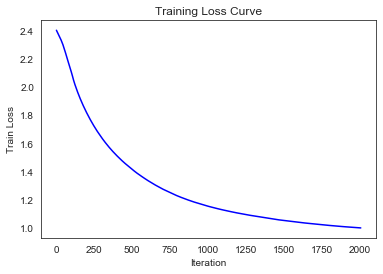

In [162]:
plt.plot(range(len(mlp.loss_curve_)), mlp.loss_curve_, c='blue')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')

In [163]:
# Adjust hidden layer parameters.
mlp1 = MLPClassifier(
    hidden_layer_sizes=(5,2,), random_state=15, max_iter=5000, alpha=0.01)
mlp1.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [164]:
# Find accuracy score.
mlp1.score(X_train_tfidf, y_train)

0.7908745247148289

In [165]:
# Cross-validation.
cross_val_score(mlp1, X_train_tfidf, y_train, cv=5)

array([0.26605505, 0.26168224, 0.25233645, 0.22115385, 0.19191919])

Text(0, 0.5, 'Train Loss')

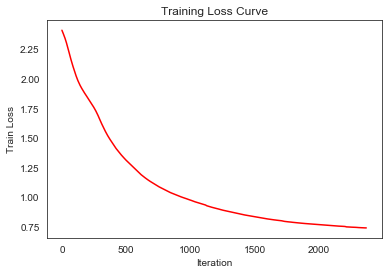

In [166]:
plt.plot(range(len(mlp1.loss_curve_)), mlp1.loss_curve_, c='red')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')

In [167]:
# Adjust hidden layer parameters.
mlp2 = MLPClassifier(
    hidden_layer_sizes=(5,2,), random_state=15, max_iter=5000, alpha=0.05)
mlp2.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=15, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [168]:
# Find accuracy score.
mlp2.score(X_train_tfidf, y_train)

0.7661596958174905

In [169]:
# Cross-validation.
cross_val_score(mlp2, X_train_tfidf, y_train, cv=5)

array([0.29357798, 0.21495327, 0.22429907, 0.21153846, 0.25252525])

Text(0, 0.5, 'Train Loss')

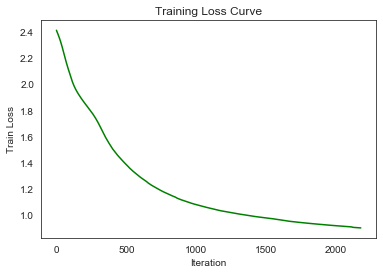

In [170]:
plt.plot(range(len(mlp2.loss_curve_)), mlp2.loss_curve_, c='green')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')

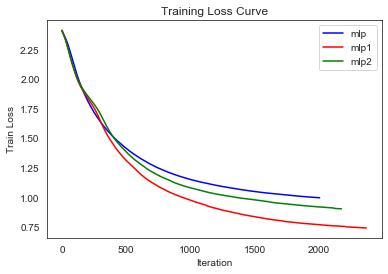

In [171]:
plt.plot(range(len(mlp.loss_curve_)), mlp.loss_curve_, c='blue', label='mlp')
plt.plot(range(len(mlp1.loss_curve_)), mlp1.loss_curve_, c='red', label='mlp1')
plt.plot(range(len(mlp2.loss_curve_)),
         mlp2.loss_curve_, c='green', label='mlp2')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')
plt.legend()